# NBA Forecast
We will attempt to forecast points scored at the next game for each team. Our focus is on engineering features from time series data.

In [2]:
# !pip install -q -U ipython ipython-sql
# !pip install sqlalchemy==2.0.0

In [1]:
# import sqlite3 as sql
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

The connection has ceased updating the data fed through this connection so it goes up to 2023-02-26. To pull the data, the sql connection file must be present, and the code below should be uncommented. However, the files are available in this folder, so it is unnecessary to pull new data.

In [3]:
# conn = sql.connect('/Users/rena/Desktop/ds-tutorials/NBA_forecast_time_series/nba.sqlite') # create connection object to database
# df_games = pd.read_sql('select * from game', conn)
# df_games.to_csv('nba_games.csv')
# df_games.shape

In [89]:
df_games = pd.read_csv('nba_games.csv', index_col=0)
print(df_games.columns)
print(df_games['game_date'].max())
df_games.head()

Index(['season_id', 'team_id_home', 'team_abbreviation_home', 'team_name_home',
       'game_id', 'game_date', 'matchup_home', 'wl_home', 'min', 'fgm_home',
       'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home',
       'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home',
       'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home',
       'pts_home', 'plus_minus_home', 'video_available_home', 'team_id_away',
       'team_abbreviation_away', 'team_name_away', 'matchup_away', 'wl_away',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'pts_away', 'plus_minus_away', 'video_available_away'],
      dtype='object')
2023-02-26 00:00:00


,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away
0,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68,2,0
1,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,25.0,51,-5,0
2,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,-6,0
3,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,22.0,47,-16,0
4,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,17,0


Capturing Seasonality with Datetime

pd.to_datetime converts series values to datetime objects

dt.day extracts the day of the month (1-31) from a datetime series object like one in Pandas or Polars. 

dt.dayofweek extracts the day of week as an integer (Monday=0, Sunday=6). 

dt.dayofyear extracts the day of year as an integer (1-366). 

dt.isocalendar().week extracts the week of the year, where week 1 contains the first Thursday of the month and the week begins from Monday. This can lead to the first few days of January being assigned to the last week of the previous year.

dt.month extracts the month of the year as an integer (Jan=1, Feb=2,..., Dec=12)

<p align="center">
  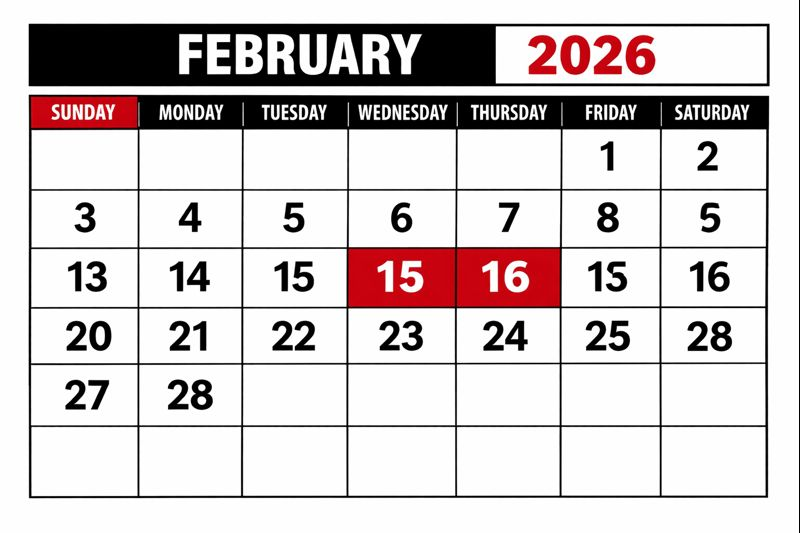
</p>


In [120]:
# Python dt built-ins
dates = pd.to_datetime(df_games['game_date'])
df_games['day_of_week'] = dates.dt.dayofweek
df_games['day_of_month'] = dates.dt.day
df_games['day_of_year'] = dates.dt.dayofyear
df_games['week_of_year'] = dates.dt.isocalendar().week
df_games['month_of_year'] = dates.dt.month
df_games['year'] = dates.dt.year
df_games['is_weekend'] = dates.dt.dayofweek.isin([5, 6]).astype(int)
df_games['is_month_start'] = dates.dt.is_month_start.astype(int)
df_games['is_month_end']   = dates.dt.is_month_end.astype(int)
df_games['is_leap_year']   = dates.dt.is_leap_year.astype(int)

## Cyclical Trigonometry Transformations

<p align="center">
  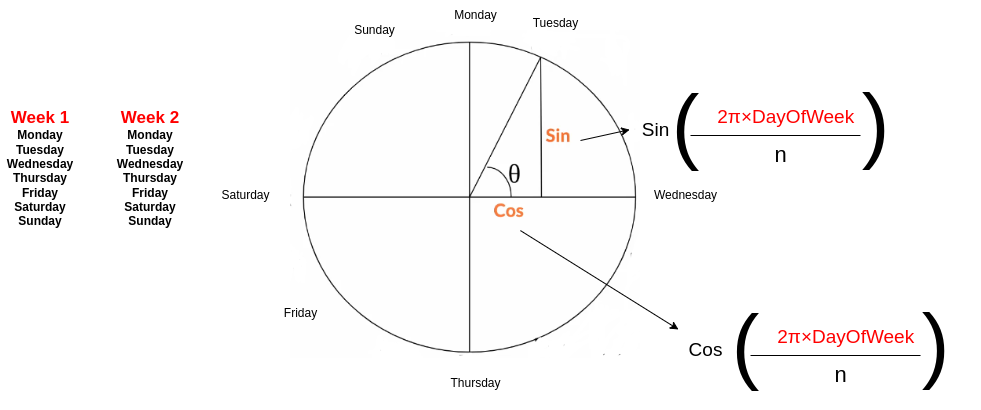
</p>

In [12]:
df_games['sin_day_of_week'] = np.sin(2*np.pi*(df_games['day_of_week'])/7)
df_games['cos_day_of_week'] = np.cos(2*np.pi*(df_games['day_of_week'])/7)

df_games['sin_day_of_month'] = np.sin(2*np.pi*(df_games['day_of_month'])/31)
df_games['cos_day_of_month'] = np.cos(2*np.pi*(df_games['day_of_month'])/31)

df_games['sin_day_of_year'] = np.sin(2*np.pi*(df_games['day_of_year'])/365)
df_games['cos_day_of_year'] = np.cos(2*np.pi*(df_games['day_of_year'])/365)

df_games['sin_week_of_year'] = np.sin(2 * np.pi * df_games['week_of_year'] / 52)
df_games['cos_week_of_year'] = np.cos(2 * np.pi * df_games['week_of_year'] / 52)

df_games['sin_month_of_year'] = np.sin(2 * np.pi * df_games['month_of_year'] / 12)
df_games['cos_month_of_year'] = np.cos(2 * np.pi * df_games['month_of_year'] / 12)

## Seasonality vs NBA Season
What about the cycle within each NBA season? Games are only played October-February, so we can create a feature showing the cyclical nature within that time frame as opposed to 365 days per year.

A season_id matches up with the year the season starts, but seasons may end the following year.

In [91]:
# NBA Season
# progress through the season since first game per team per season
home = df_games[['season_id', 'game_date', 'team_name_home']].rename(columns={'team_name_home': 'team_name'})
away = df_games[['season_id', 'game_date', 'team_name_away']].rename(columns={'team_name_away': 'team_name'})
teams_long = pd.concat([home, away], ignore_index=True)

# count unique team seasons overall
count_seasons_per_team = (teams_long.groupby('team_name')['season_id'].nunique().reset_index(name='num_seasons'))
print(count_seasons_per_team.num_seasons.sum())
season_first_game = (teams_long.sort_values('game_date').groupby(['team_name', 'season_id'], 
    as_index=False).first()).rename(columns={'game_date': 'season_start_date'})

# datetime extractions
# season_dates = pd.to_datetime(season_first_game['season_start_date'])
# season_first_game['season_start_day_of_week']  = season_dates.dt.dayofweek
# season_first_game['season_start_day_of_month'] = season_dates.dt.day
# season_first_game['season_start_day_of_year']  = season_dates.dt.dayofyear
# season_first_game['season_start_week_of_year'] = season_dates.dt.isocalendar().week
# season_first_game['season_start_month_of_year'] = season_dates.dt.month
# season_first_game['season_start_year'] = season_dates.dt.year
# season_first_game['season_start_is_weekend'] = (season_dates.dt.dayofweek.isin([5, 6]).astype(int))
# season_first_game['season_start_is_month_start'] = season_dates.dt.is_month_start.astype(int)
# season_first_game['season_start_is_month_end']   = season_dates.dt.is_month_end.astype(int)
# season_first_game['season_start_is_leap_year']   = season_dates.dt.is_leap_year.astype(int)
# low_signal_features = ['season_start_day_of_month', 'season_start_day_of_year','season_start_is_month_start', 
#                        'season_start_is_month_end','season_start_is_leap_year']
# print(season_first_game.shape)
# season_first_game.head()


# season_start_date merged with original game data
df_games = df_games.merge(season_first_game[['team_name', 'season_id', 'season_start_date']],left_on=['team_name_home', 'season_id'],
    right_on=['team_name', 'season_id'],how='left').rename(columns={'season_start_date': 'home_season_start_date'}).drop(columns='team_name')
df_games = df_games.merge(season_first_game[['team_name', 'season_id', 'season_start_date']],left_on=['team_name_away', 'season_id'],
    right_on=['team_name', 'season_id'],how='left').rename(columns={'season_start_date': 'away_season_start_date'}).drop(columns='team_name')
df_games[['game_date','team_name_home','team_name_away','home_season_start_date','away_season_start_date']].tail()

1578


,game_date,team_name_home,team_name_away,home_season_start_date,away_season_start_date
62261,2023-02-26 00:00:00,Portland Trail Blazers,Houston Rockets,2022-10-19 00:00:00,2022-10-19 00:00:00
62262,2023-02-26 00:00:00,Denver Nuggets,LA Clippers,2022-10-19 00:00:00,2022-10-20 00:00:00
62263,2023-02-26 00:00:00,Dallas Mavericks,Los Angeles Lakers,2022-10-19 00:00:00,2022-10-18 00:00:00
62264,2023-02-26 00:00:00,Cleveland Cavaliers,Toronto Raptors,2022-10-19 00:00:00,2022-10-19 00:00:00
62265,2023-02-26 00:00:00,Chicago Bulls,Washington Wizards,2022-10-19 00:00:00,2022-10-19 00:00:00


## Season Progress
### Normalization
Should we normalize the days by the season length? NO! That would cause DATA LEAKAGE, because season lengths are not known until a team wins enough games to enter playoffs etc.. Basically the model would know the team makes it to the playoffs before they do, and that is just not possible.

In [61]:
df_games['home_season_days'] = (pd.to_datetime(df_games[
    'game_date']) - pd.to_datetime(df_games['home_season_start_date'])).dt.days
df_games['away_season_days'] = (pd.to_datetime(df_games[
    'game_date']) - pd.to_datetime(df_games['away_season_start_date'])).dt.days
df_games['season_progress_diff'] = (df_games[
        'home_season_days'] - df_games['away_season_days'])
df_games[['game_date','team_name_home','team_name_away','home_season_start_date',	
          'away_season_start_date',	'home_season_days',	'away_season_days',	'season_progress_diff']].tail()

,game_date,team_name_home,team_name_away,home_season_start_date,away_season_start_date,home_season_days,away_season_days,season_progress_diff
62261,2023-02-26 00:00:00,Portland Trail Blazers,Houston Rockets,2022-10-19 00:00:00,2022-10-19 00:00:00,130,130,0
62262,2023-02-26 00:00:00,Denver Nuggets,LA Clippers,2022-10-19 00:00:00,2022-10-20 00:00:00,130,129,1
62263,2023-02-26 00:00:00,Dallas Mavericks,Los Angeles Lakers,2022-10-19 00:00:00,2022-10-18 00:00:00,130,131,-1
62264,2023-02-26 00:00:00,Cleveland Cavaliers,Toronto Raptors,2022-10-19 00:00:00,2022-10-19 00:00:00,130,130,0
62265,2023-02-26 00:00:00,Chicago Bulls,Washington Wizards,2022-10-19 00:00:00,2022-10-19 00:00:00,130,130,0


In [ ]:
# for modeling
# ALL_FEATURES = [col for col in df_games.columns if col not in NON_FEATURE_COLS]


## Lags, Differences, Rolling & Expanding Statistics

What has been happening lately? What is the average behavior over all time? 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

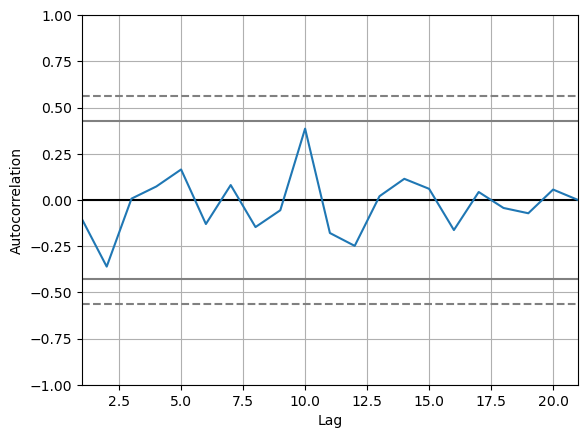

In [200]:
from statsmodels.tsa.stattools import acf

team = "Chicago Bulls"
season = 22022

series = (df_games[(df_games['team_name_home'] == team) & \
          (df_games['season_id'] == season)].sort_values('game_date')['pts_home'])

acf_vals = acf(series, nlags=20)
autocorrelation_plot(acf_vals)

In [169]:
# Lags
df_games['home_points_lag_1'] = (df_games.groupby(['team_name_home', 'season_id']) \
        ['pts_home'].shift(1))
df_games['away_points_lag_1'] = (df_games.groupby(['team_name_away', 'season_id']) \
        ['pts_away'].shift(1))
# how well do they match up?
df_games['points_lag_1_difference'] = df_games['home_points_lag_1'] - df_games['away_points_lag_1']

df_games.sort_values(by=['season_id','team_name_home','game_date'])[['season_id','game_date','team_name_home','team_name_away','pts_home',
          'pts_away','home_points_lag_1','away_points_lag_1','points_lag_1_difference']].tail()

,season_id,game_date,team_name_home,team_name_away,pts_home,pts_away,home_points_lag_1,away_points_lag_1,points_lag_1_difference
62137,22022,2023-02-03 00:00:00,Washington Wizards,Portland Trail Blazers,116,124,138.0,122.0,16.0
62162,22022,2023-02-06 00:00:00,Washington Wizards,Cleveland Cavaliers,91,114,116.0,122.0,-6.0
62171,22022,2023-02-08 00:00:00,Washington Wizards,Charlotte Hornets,118,104,91.0,112.0,-21.0
62193,22022,2023-02-11 00:00:00,Washington Wizards,Indiana Pacers,127,113,118.0,111.0,7.0
62249,22022,2023-02-24 00:00:00,Washington Wizards,New York Knicks,109,115,127.0,122.0,5.0


In [ ]:
df_games['

Features: next_opponents lags, diffs, rolling stats

In [38]:
def gimme_data(df_games,team):
    home_games=df_games[df_games['team_name_home']==team][[
        'game_id', 'game_date','team_name_home','pts_home','wl_home',
        'team_name_away','pts_away']]
    home_games['ha']='home'
    home_games=home_games.rename(columns={'team_name_home':'team_name','pts_home':'pts_scored','wl_home':'wl',
                                         'pts_away':'opp_score','team_name_away':'opp_team'})

    # home_games.rename(columns={'team_name_home','team_name'})
    away_games_df=df_games[df_games['team_name_away']==team][[
        'game_id', 'game_date','team_name_away','pts_away','wl_away','team_name_home','pts_home']]
    away_games_df['ha']='away'
    away_games_df=away_games_df.rename(columns={'team_name_away':'team_name',
                                                'pts_away':'pts_scored','wl_away':'wl',
                                               'pts_home':'opp_score','team_name_home':'opp_team'})
    one_team=pd.merge(away_games_df, home_games, how="outer").sort_values(by='game_date',ignore_index=True)
    one_team.insert(3,'next_game_points_scored',one_team['pts_scored'].shift(-1))
    one_team['wl']=one_team['wl'].replace(['W', 'L'],[1,0])
    one_team['ha']=one_team['ha'].replace(['home', 'away'],[1,0])
    return one_team

In [39]:
teams=list(pd.unique(df_games['team_name_home']))
df1=gimme_data(df_games,team=teams[0])
for team in teams[1:]:
    df=gimme_data(df_games,team=team)
    df1=pd.concat([df1, df], ignore_index=True, axis=0) 

In [44]:
df1[df1['team_name']=='Chicago Bulls'].head()

,game_id,game_date,team_name,next_game_points_scored,pts_scored,wl,opp_team,opp_score,ha
40647,0026600005,1966-10-15 00:00:00,Chicago Bulls,119.0,104,1.0,St. Louis Hawks,97,0
40648,0026600007,1966-10-18 00:00:00,Chicago Bulls,134.0,119,1.0,San Francisco Warriors,116,1
40649,0026600009,1966-10-19 00:00:00,Chicago Bulls,111.0,134,1.0,Los Angeles Lakers,124,1
40650,0026600011,1966-10-20 00:00:00,Chicago Bulls,108.0,111,0.0,San Francisco Warriors,121,0
40651,0026600015,1966-10-21 00:00:00,Chicago Bulls,105.0,108,1.0,Los Angeles Lakers,101,0


In [41]:
bulls=gimme_data(df_games,team='Chicago Bulls')
wash=gimme_data(df_games,team='Washington Wizards')
heat=gimme_data(df_games,team='Miami Heat')
bulls.tail()

,game_id,game_date,team_name,next_game_points_scored,pts_scored,wl,opp_team,opp_score,ha
4408,0022200863,2023-02-13 00:00:00,Chicago Bulls,113.0,91,0,Orlando Magic,100,1
4409,0022200874,2023-02-15 00:00:00,Chicago Bulls,100.0,113,0,Indiana Pacers,117,0
4410,0022200883,2023-02-16 00:00:00,Chicago Bulls,131.0,100,0,Milwaukee Bucks,112,1
4411,0022200900,2023-02-24 00:00:00,Chicago Bulls,102.0,131,1,Brooklyn Nets,87,1
4412,0022200912,2023-02-26 00:00:00,Chicago Bulls,NaN,102,1,Washington Wizards,82,1


In [9]:
wash.tail()

,game_id,game_date,team_name,next_game_points_scored,pts_scored,wl,opp_team,opp_score,location,opps_next_game_points
1955,0022200866,2023-02-13 00:00:00,Washington Wizards,126.0,126,0,Golden State Warriors,135,0,101.0
1956,0022200872,2023-02-14 00:00:00,Washington Wizards,114.0,126,1,Portland Trail Blazers,101,0,106.0
1957,0022200884,2023-02-16 00:00:00,Washington Wizards,109.0,114,1,Minnesota Timberwolves,106,0,115.0
1958,0022200895,2023-02-24 00:00:00,Washington Wizards,82.0,109,0,New York Knicks,115,1,102.0
1959,0022200912,2023-02-26 00:00:00,Washington Wizards,NaN,82,0,Chicago Bulls,102,0,NaN


In [12]:
def train_test_split(team_df,cut_date):
    train_df=team_df[team_df['game_date']<=cut_date]
    test_df=team_df[team_df['game_date']>cut_date]
    return train_df, test_df
def x_y_train(train_df,test_df):
    X_train=train_df[['pts_scored','wl','opp_score','location']]
    y_train=train_df['next_game_points_scored']
    X_test=test_df[['pts_scored','wl','opp_score','location']]
    y_test=test_df['next_game_points_scored']
    return  X_train, y_train, X_test, y_test
def one_team_forecast(team_1,cut_date):
    team1_train_df, team1_test_df = train_test_split(team_df=team_1,cut_date=cut_date)
    team1_X_train, team1_y_train, team1_X_test, team1_y_test = x_y_train(team1_train_df,team1_test_df)
    team1_reg = GradientBoostingRegressor(random_state=7)
    team1_reg.fit(team1_X_train, team1_y_train)
    team1_preds=team1_reg.predict(team1_X_test)
    team1_test_df.insert(4,'forecast_next_game',team1_preds)
    return team1_test_df

In [13]:
one_team_forecast(team_1=bulls,cut_date='2023-02-24')

,game_id,game_date,team_name,next_game_points_scored,forecast_next_game,pts_scored,wl,opp_team,opp_score,location,opps_next_game_points
4411,0022200900,2023-02-24 00:00:00,Chicago Bulls,102.0,108.572427,131,1,Brooklyn Nets,87,1,82.0
4412,0022200912,2023-02-26 00:00:00,Chicago Bulls,NaN,101.243712,102,1,Washington Wizards,82,1,NaN


In [14]:
one_team_forecast(team_1=wash,cut_date='2023-02-12')

,game_id,game_date,team_name,next_game_points_scored,forecast_next_game,pts_scored,wl,opp_team,opp_score,location,opps_next_game_points
1955,0022200866,2023-02-13 00:00:00,Washington Wizards,126.0,114.265546,126,0,Golden State Warriors,135,0,101.0
1956,0022200872,2023-02-14 00:00:00,Washington Wizards,114.0,105.268862,126,1,Portland Trail Blazers,101,0,106.0
1957,0022200884,2023-02-16 00:00:00,Washington Wizards,109.0,107.646598,114,1,Minnesota Timberwolves,106,0,115.0
1958,0022200895,2023-02-24 00:00:00,Washington Wizards,82.0,105.816881,109,0,New York Knicks,115,1,102.0
1959,0022200912,2023-02-26 00:00:00,Washington Wizards,NaN,93.582979,82,0,Chicago Bulls,102,0,NaN
